# Conditional Generative Adversarial Network (cGAN)
* Thay thế việc dùng Generator để sinh ảnh mới giống vs trong dataset mà ko kiểm soát đc thuộc categorical nào
* Ta sẽ quyết định đc Generator sinh ảnh theo 1 categorical nhất định

## Generator
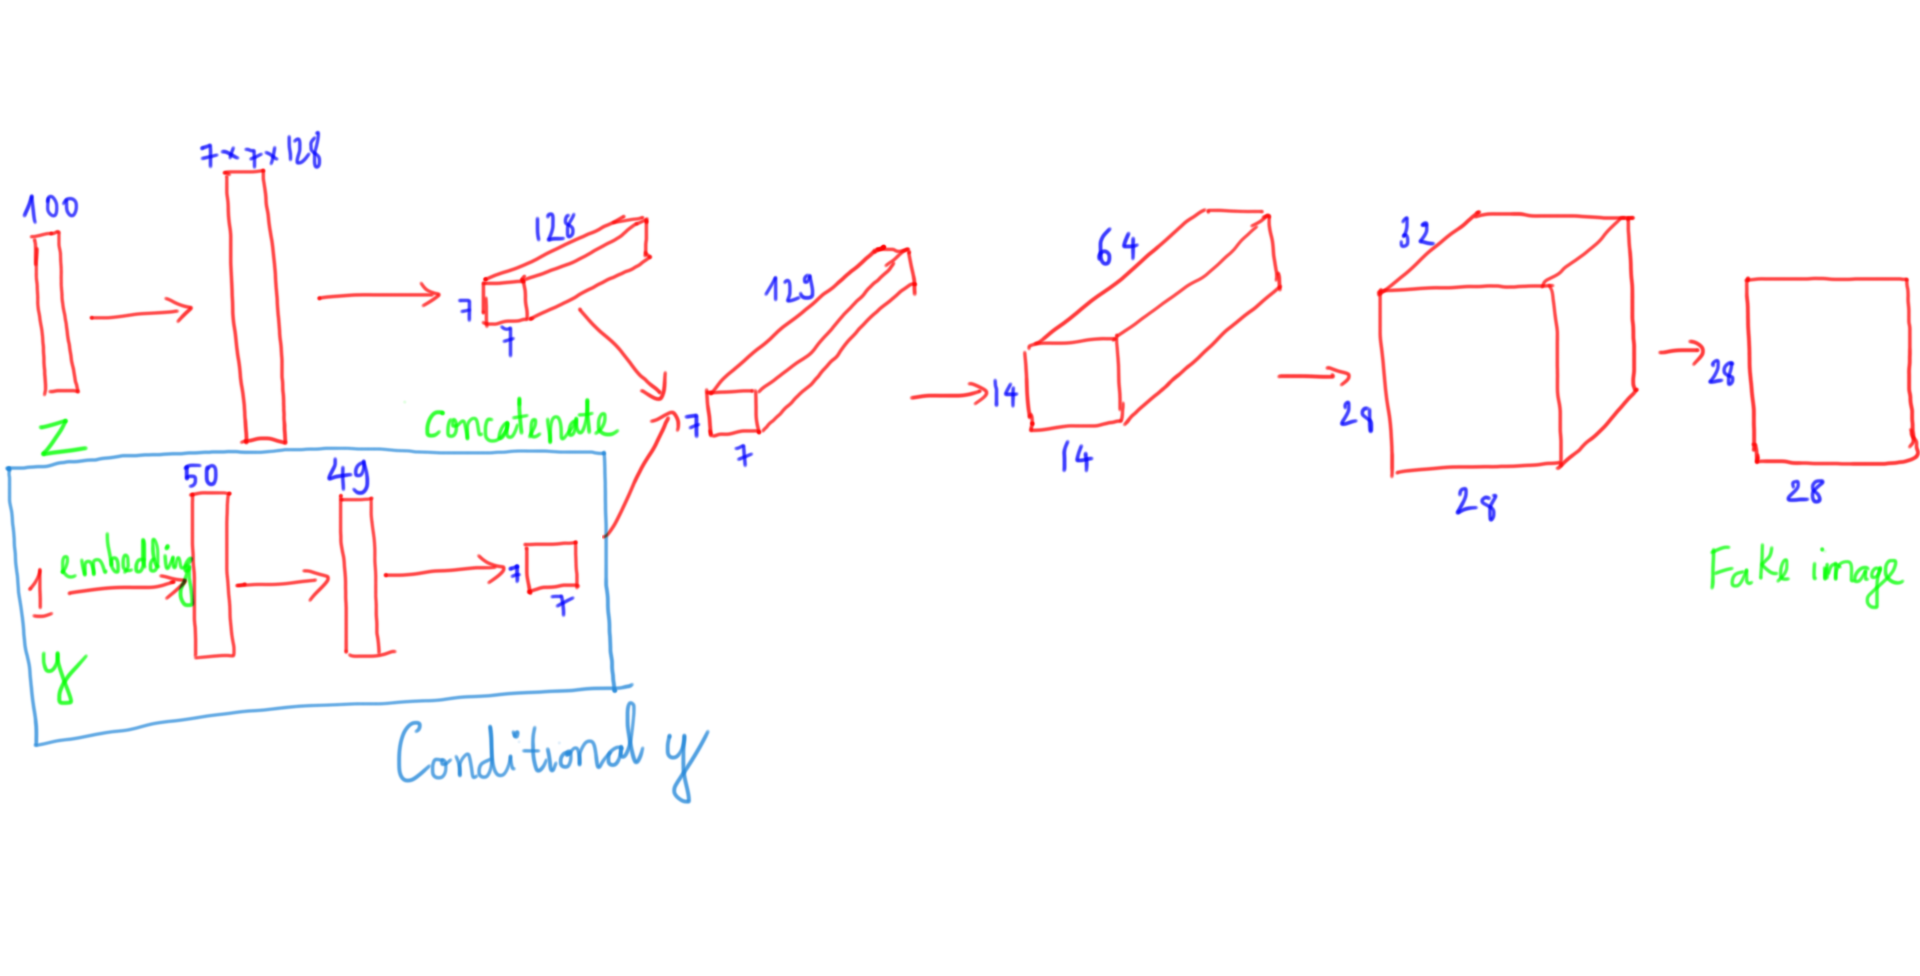
* Ngoài việc Input là noise vector $z$ thì sẽ thêm vào 1 số $y$ (đại diện cho label)
* Ta mong muốn $z$ vs số $y$ nào thì sẽ cho ra dữ liệu tương ứng thể loại ấy

|         Input y         |           Input z           |                 Input2Output (Shape)                |
|:-----------------------:|:---------------------------:|:---------------------------------------------------:|
|            X            |   Dense (fully-connected)   |           (100,) $\rightarrow$ (7, 7, 128)          |
|        Embedding        |              X              |                1 $\rightarrow$ (50,)                |
| Dense (fully-connected) |              X              |              (50,) $\rightarrow$ (49,)              |
|         Reshape         |              X              |              (49,) $\rightarrow$ (7, 7)             |
|       Concatenate       |         Concatenate         | (7, 7, 128) concat (7, 7) $\rightarrow$ (7, 7, 129) |
|   ********************  |     ********************    |                 ********************                |
|          **X**          | **Input after concatenate** |               **Input2Output (Shape)**              |
|            X            |   Transposed Convolutional  |        (7, 7, 129) $\rightarrow$ (14, 14, 64)       |
|            X            |   Transposed Convolutional  |       (14, 14, 64) $\rightarrow$ (28, 28, 32)       |
|            X            |         Convolution         |         (28, 28, 32) $\rightarrow$ (28, 28)         |

## Discriminator
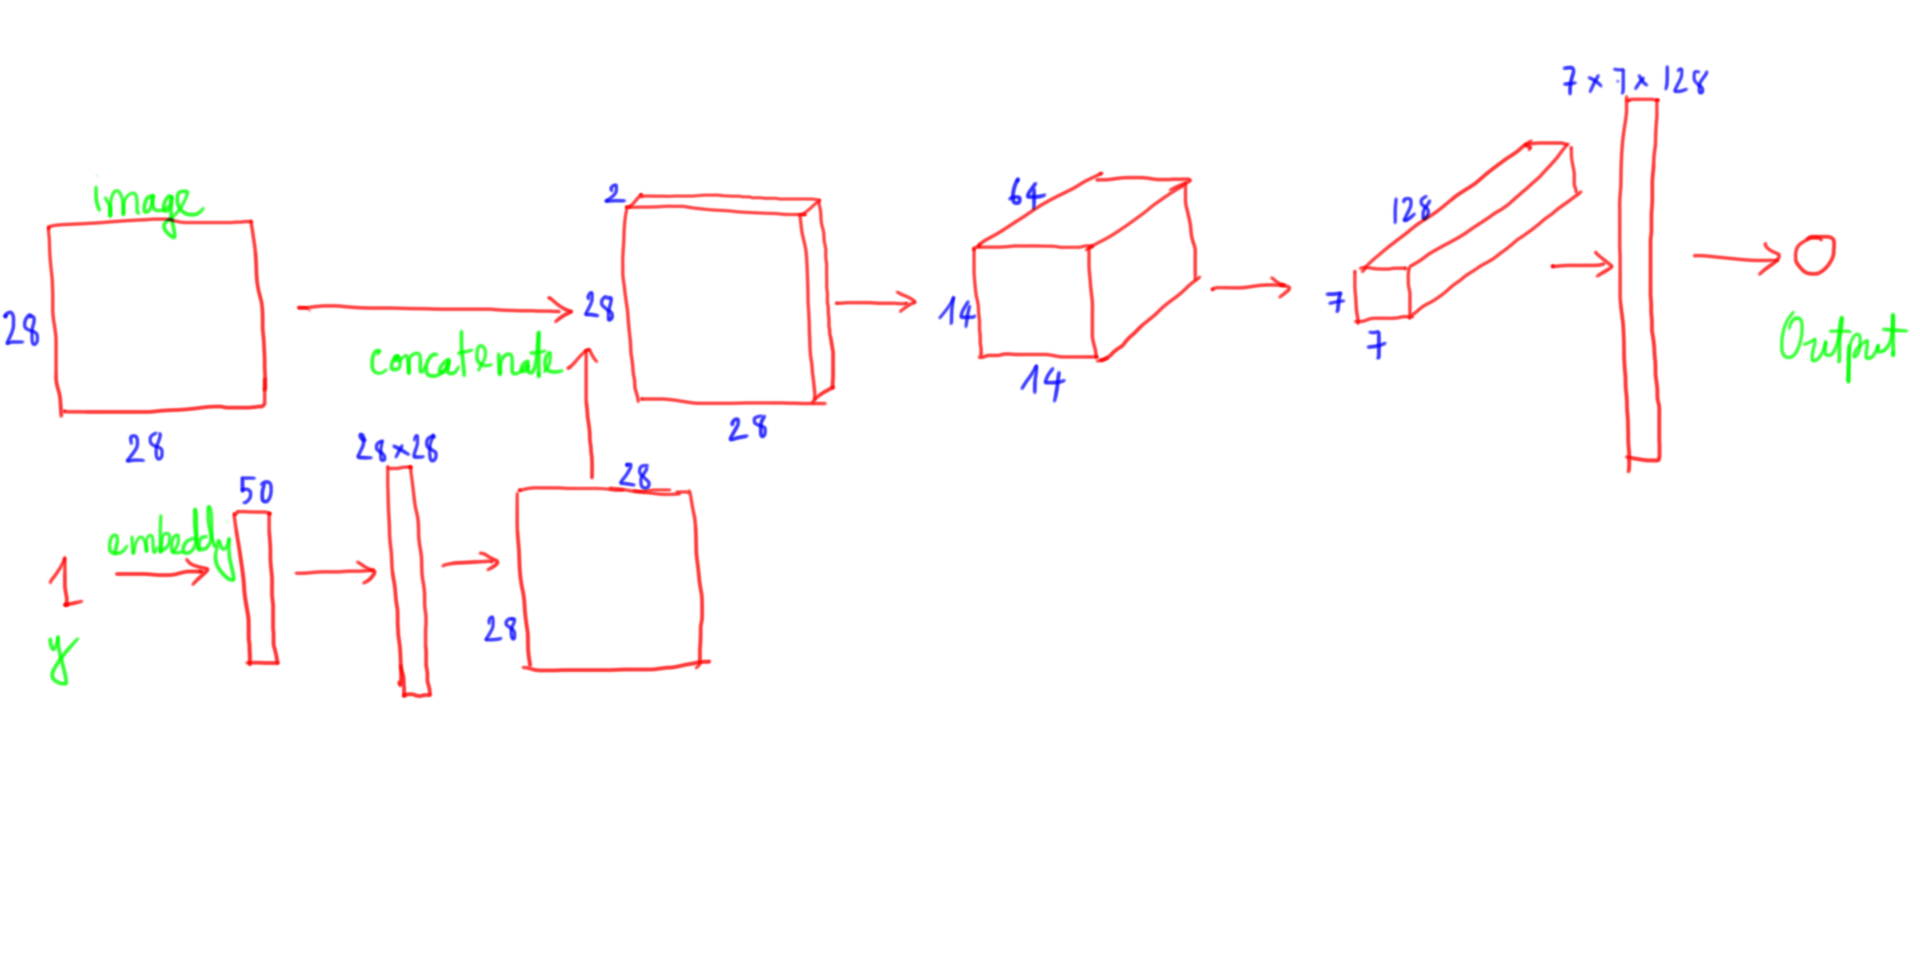
* Phần này ta cũng sẽ thêm $y$ vào giống như Generator

|         Input y         |           Input z           |                Input2Output (Shape)                |
|:-----------------------:|:---------------------------:|:--------------------------------------------------:|
|            X            |            Image            |                      (28, 28)                      |
|        Embedding        |              X              |                1 $\rightarrow$ (50,)               |
| Dense (fully-connected) |              X              |             (50,) $\rightarrow$ (784,)             |
|         Reshape         |              X              |            (784,) $\rightarrow$ (28, 28)           |
|       Concatenate       |         Concatenate         | (28, 28) concat (28, 28) $\rightarrow$ (28, 28, 2) |
|   ********************  |     ********************    |                ********************                |
|          **X**          | **Input after concatenate** |              **Input2Output (Shape)**              |
|            X            |   Convolution (stride = 2)  |       (28, 28, 2) $\rightarrow$ (14, 14, 64)       |
|            X            |   Convolution (stride = 2)  |       (14, 14, 64) $\rightarrow$ (7, 7, 128)       |
|            X            |           Flatten           |          (7, 7, 128) $\rightarrow$ (6272,)         |
|            X            |    Dense (fully-connect)    |               (6272,) $\rightarrow$ 1              |

## Loss function
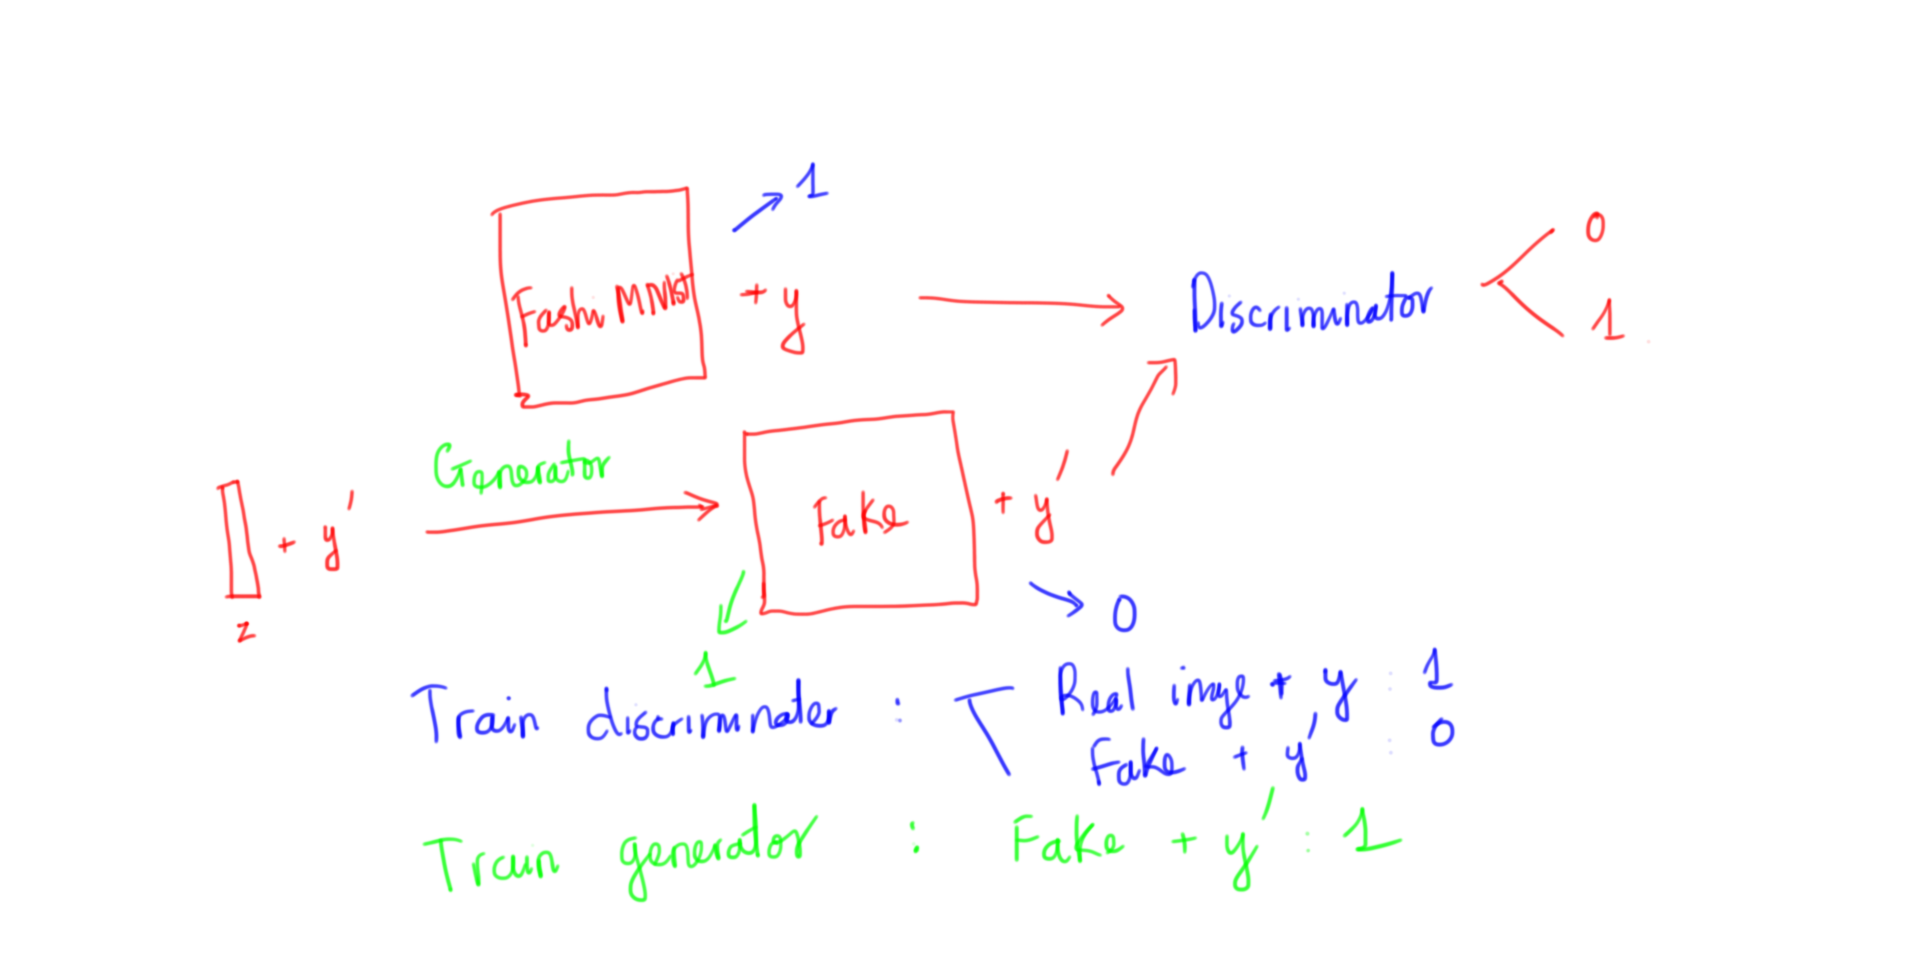

### Fashion mnist: Gồm 60000 ảnh training và 10000 ảnh test kích thước (28, 28) gồm 10 lớp khác nhau

| Label | Description |
|:-----:|:-----------:|
|   0   | T-shirt/top |
|   1   |   Trouser   |
|   2   |   Pullover  |
|   3   |    Dress    |
|   4   |     Coat    |
|   5   |    Sandal   |
|   6   |    Shirt    |
|   7   |   Sneaker   |
|   8   |     Bag     |
|   9   |  Ankle boot |

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math, random, os
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tqdm.notebook import tqdm

In [2]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_train = np.expand_dims(X_train, axis = -1)
X_train = X_train.astype('float32') / 255.0
X_train = 2 * X_train - 1

X_test = np.expand_dims(X_test, axis = -1)
X_test = X_test.astype('float32') / 255.0
X_test = 2 * X_test - 1

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28, 1)
(60000,)
(10000, 28, 28, 1)
(10000,)


In [3]:
def build_generator(z_dims, n_classes = 10):
    # Label input
    in_label = Input(shape = (1,))
    li = Embedding(n_classes, 50)(in_label)
    li = Dense(7 * 7)(li)
    li = Reshape((7, 7, 1))(li)
    # noise input
    in_noise = Input(shape = (z_dims,))
    ni = Dense(7 * 7 * 128)(in_noise)
    ni = LeakyReLU(alpha = 0.2)(ni)
    ni = Reshape((7, 7, 128))(ni)
    # Concatenate
    merge = Concatenate()([ni, li])
    merge = Conv2DTranspose(64, kernel_size = (4, 4), strides = (2, 2), padding = 'same')(merge)
    merge = LeakyReLU(alpha = 0.2)(merge)
    merge = Conv2DTranspose(32, kernel_size = (4, 4), strides = (2, 2), padding = 'same')(merge)
    merge = LeakyReLU(alpha = 0.2)(merge)
    outputs = Conv2D(1, kernel_size = (7, 7), activation = 'tanh', padding = 'same')(merge)
    
    model = Model(inputs = [in_noise, in_label], outputs = outputs)
    return model

In [4]:
def build_discriminator(in_shape = (28, 28, 1), n_classes = 10):
    # Label input
    in_label = Input(shape = (1,))
    li = Embedding(n_classes, 50)(in_label)
    li = Dense(in_shape[0] * in_shape[1])(li)
    li = Reshape((in_shape[0], in_shape[1], 1))(li)
    # Image input
    in_img = Input(shape = in_shape)
    # Concatenate
    merge = Concatenate()([in_img, li])
    merge = Conv2D(64, kernel_size = (3, 3), strides = (2, 2), padding = 'same')(merge)
    merge = LeakyReLU(alpha = 0.2)(merge)
    merge = Conv2D(128, kernel_size = (3, 3), strides = (2, 2), padding = 'same')(merge)
    merge = LeakyReLU(alpha = 0.2)(merge)
    merge = Flatten()(merge)
    merge = Dropout(0.4)(merge)
    outputs = Dense(1, activation = 'sigmoid')(merge)
    
    model = Model(inputs = [in_img, in_label], outputs = outputs)
    adam = Adam(learning_rate = 2e-4, beta_1 = 0.5)
    model.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [5]:
# For updating gan
def build_gan(g_model, d_model):
    d_model.trainable = False
    
    # Get noise and label inputs from Generator
    g_noise, g_label = g_model.input
    # Get image output from Generator
    g_output = g_model.output
    
    # Connect image output and label input from Generator as inputs to Discriminator
    gan_output = d_model([g_output, g_label])
    # Define gan
    model = Model(inputs = [g_noise, g_label], outputs = gan_output)
    adam = Adam(learning_rate = 2e-4, beta_1 = 0.5)
    model.compile(optimizer = adam, loss = 'binary_crossentropy')
    return model

In [6]:
# Generate noise for Generator
def generate_points(z_dims, n_samples, n_classes = 10):
    # Generate noise and Reshape into a batch of inputs
    x_inputs = np.random.randn(z_dims * n_samples)
    z_inputs = x_inputs.reshape(n_samples, z_dims)
    
    # Generate labels
    labels = np.random.randint(0, n_classes, size = n_samples)
    return [z_inputs, labels]

In [7]:
# Generate n fake samples with class labels
def generate_fake_samples(g_model, z_dims, n_samples, n_classes = 10):
    z_inputs, labels_input = generate_points(z_dims, n_samples)
    # Predict outputs
    images = g_model.predict([z_inputs, labels_input])
    # Create class labels
    y = np.zeros((n_samples, 1))
    return [images, labels_input], y

In [8]:
# Select real samples
def generate_real_samples(dataset, n_samples, n_classes = 10):
    images, labels = dataset
    ix = np.random.randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = np.ones((n_samples, 1))
    return [X, labels], y

In [9]:
def plot_imgs(imgs, path, n_rows = 10, n_cols = 10):
    imgs = (imgs + 1) / 2.0
    count = 0
    fig, axes = plt.subplots(n_rows, n_cols)
    
    for j in range(n_rows):
        for i in range(n_cols):
            axes[j, i].axis('off')
            axes[j, i].imshow(imgs[count, :, :, :], cmap = 'gray_r', interpolation = 'nearest')
            count += 1
    # plt.tight_layout()
    plt.show()

In [11]:
def plot_losses(g_loss, d_loss, filename):
    fig, axes = plt.subplots(1, 2, figsize = (8, 2))
    axes[0].plot(g_loss)
    axes[1].plot(d_loss)
    axes[0].set_title('Generater loss')
    axes[1].set_title('Discriminator loss')
    # plt.savefig(filename)
    plt.tight_layout()
    plt.show()

In [12]:
def train(g_model, d_model, gan_model, dataset, z_dims = 100, epochs = 300, batch_size = 128, plot_frequency = 10):
    img_shape = X_train[0].shape
    print('Image shape: {}, min value: {}, max value: {}'.format(img_shape, np.min(X_train[0]), np.max(X_train[0])))
    batch_per_epoch = X_train.shape[0] // batch_size
    half_batch = batch_size // 2
    
    g_losses, d_losses = [], []
    
    for e in tqdm(range(1, epochs + 1), desc = 'Progress bar'):
        for i in tqdm(range(batch_per_epoch), leave = False, desc = 'Epoch %d' % e):
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            # Update Discriminator model weights
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            
            # Generate fake examples
            [X_fake, labels], y_fake = generate_fake_samples(g_model, z_dims, half_batch)
            
            # Ipdate Discriminator model weights
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            
            d_loss = d_loss1 + d_loss2
            
            # Prepare points as input for the generator
            [z_input, labels_input] = generate_points(z_dims, batch_size)
            
            # Create labels
            y_gan = np.ones((batch_size, 1))
            
            # Update Generator via Discriminator's error
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            
            g_losses.append(g_loss)
            d_losses.append(d_loss)
            
            if (e % plot_frequency == 0 or e == 1) and i == 0:
                print('-' * 15, 'Epoch %d' % e, '-' * 15)
                
                z_dims2, labels2 = generate_points(100, 100)
                labels2 = np.asarray([x for _ in range(10) for x in range(10)])
                
                fake_imgs = g_model.predict([z_dims2, labels2])
                print(fake_imgs.shape)
                plot_imgs(fake_imgs, 'Images1/fake_images_e_{}.png'.format(e))
    plot_losses(g_losses, d_losses, 'losses.png')
    g_model.save('cgan_generator.h5')

In [ ]:
z_dims = 100

g_model = build_generator(z_dims = z_dims)
d_model = build_discriminator()

gan_model = build_gan(g_model, d_model)
# load image data
dataset = [X_train, y_train]
# train model
train(g_model, d_model, gan_model, dataset, z_dims = z_dims, epochs = 10)